In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#calculamos los parámetros de las galaxias 
#r50, r90, rgal, M90, Mgal, Mgas, Mvir, A2max, Rmax, krot

import matplotlib.pyplot as plt
import h5py
import rotation as rot
import barstrength1 as strng
import kapparot as krot

a0=1

vector = (1,2,4)
snapshot = np.loadtxt('/z/dalgorry/snapshots.txt', dtype='string')


for j in range(len(snapshot)-1,0,-1):
    snap = h5py.File('../outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')
    #print j, snapshot[j]
    print snapshot[j]

    for i in range(0,3):
        fo =open('/z/dalgorry/datos_salida2/A2-krot-s'+'%s' %vector[i]+'.dat','a')

        cm   = snap['subhalo_00'+ str('%s' %vector[i])+ '/Center'].value
        r200 = snap['subhalo_00'+ str('%s' %vector[i])+ '/R200'].value
        time = snap['subhalo_00'+ str('%s' %vector[i])+ '/Time'].value
        h = snap['subhalo_00'+ str('%s' %vector[i])+ '/h'].value
        aexp = snap['subhalo_00'+ str('%s' %vector[i])+ '/aexp'].value

        pstr = snap['subhalo_00'+ str('%s'%vector[i]) + '/Str/Coordinates'].value
        masa_str = snap['subhalo_00'+ str('%s' %vector[i]) + '/Str/Masses'].value
        vel  = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Velocities'].value

        pgas = snap['subhalo_00'+ str('%s' %vector[i])+ '/Gas/Coordinates'].value
        masa_gas = snap['subhalo_00'+ str('%s' %vector[i])+ '/Gas/Masses'].value

        pdrk = snap['subhalo_00'+ str('%s' %vector[i]) + '/Drk/Coordinates'].value
        masa_drk = snap['subhalo_00'+ str('%s' %vector[i])+ '/Drk/Masses'].value

#---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = pstr[:,0]-cm[0]
        ystr = pstr[:,1]-cm[1]
        zstr = pstr[:,2]-cm[2]
        r = np.sqrt(xstr**2+ystr**2+zstr**2)

        xgas = pgas[:,0]-cm[0]
        ygas = pgas[:,1]-cm[1]
        zgas = pgas[:,2]-cm[2]
        rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

        xdrk = pdrk[:,0]-cm[0]
        ydrk = pdrk[:,1]-cm[1]
        zdrk = pdrk[:,2]-cm[2]
        rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)
#------------------------------------------------
        r200 = r200*aexp
        rgal=0.15*r200

        limit = np.where(r<rgal)
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])

        limit_gas = np.where(rgas<rgal)
        rgas_sort = np.sort(rgas[limit_gas])
        rgas_indice = np.argsort(rgas[limit_gas])

        limit_drk = np.where(rdrk<r200)
        rdrk_sort = np.sort(rdrk[limit_drk])
        rdrk_indice = np.argsort(rdrk[limit_drk])

        Mc_str = cumsum((masa_str[limit])[r_indice])
        M_gal = Mc_str[-1]

        Mc_gas = cumsum((masa_gas[limit_gas])[rgas_indice])
        M_gas = Mc_gas[-1]

        Mc_drk = cumsum((masa_drk[limit_drk])[rdrk_indice])
        M_drk = Mc_drk[-1]
#------------------ calculamos M90------------------------------------------
        razon = Mc_str/M_gal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)

        r90 = r_sort[noventa]
        r50 = r_sort[cincuenta]
        M90 = Mc_str[noventa]                

#------------------masa total en r200 (Mvir)--------------------------
        rvir= concatenate([r,rgas,rdrk])
        mvir= concatenate([masa_str, masa_gas, masa_drk])

        limit_vir = np.where(rvir<r200)
        rvir_sort = np.sort(rvir[limit_vir])
        rvir_indice = np.argsort(rvir[limit_vir])

        Mc_vir = cumsum((mvir[limit_vir])[rvir_indice])

        M_vir = Mc_vir[-1]

#-------------------------------------------------------------------            
        corte1,=np.where(r<r90[-1])
        corte2,=np.where(r<2*r50[-1])
        veloc,=np.where(r<r50[-1])

#----------componentes de la velocidad del centro de masa------------
        vxcm = sum(masa_str[veloc]*vel[veloc,0])/sum(masa_str[veloc])
        vycm = sum(masa_str[veloc]*vel[veloc,1])/sum(masa_str[veloc])
        vzcm = sum(masa_str[veloc]*vel[veloc,2])/sum(masa_str[veloc])

#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
        vx = vel[:,0] - vxcm
        vy = vel[:,1] - vycm
        vz = vel[:,2] - vzcm

        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(masa_str,xstr,ystr,zstr,vx,vy,vz,r90[-1])

        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz


        A2max, rmax = strng.a2max(masa_str[corte2], xn[corte2], yn[corte2], 20)

        k_rot = krot.kapa(masa_str[corte1], xn[corte1], yn[corte1], zn[corte1],
                          vxn[corte1], vyn[corte1], vzn[corte1])

        fo.write(str('%.6f'% time) +'\t'+
                 str('%12.6f'% r50[-1]) +'\t'+
                 str('%12.6f'% rgal) +'\t'+
                 str('%12.6f'% r200) +'\t'+
                 str('%12.6f'% A2max) +'\t'+
                 str('%12.6f'% k_rot)+'\t'+
                 str('%12.6f'% log10(M_gal)) +'\t'+
                 str('%12.6f'% log10(M_gas)) +'\t'+
                 str('%12.6f'% log10(M_vir)) +'\t'+
                 str('%12.6f'% log10(M_drk)) +'\n')
        fo.close()

1024
1008
0992
0976
0960
0944
0928
0912
0896
0880
0864
0848
0832
0816
0800
0784
0768
0752
0736
0720
0704
0688
0672
0656
0640
0624
0608
0592
0576
0560
0544
0528
0512
0496
0480
0464
0453
0448
0432
0416
0400
0384
0368
0352
0336
0320
0304
0288
0272
0256
0240
0224
0208
0192
0176
0160
0144
0128
0112


In [1]:
import h5py
snap = h5py.File('../outputs2/snap_0112.h5py', 'r')
def printname(name):
    print name
snap.visit(printname)

subhalo_001
subhalo_001/Center
subhalo_001/Drk
subhalo_001/Drk/Coordinates
subhalo_001/Drk/Masses
subhalo_001/Drk/Velocities
subhalo_001/Gas
subhalo_001/Gas/Coordinates
subhalo_001/Gas/Masses
subhalo_001/Gas/Velocities
subhalo_001/OmegaL0
subhalo_001/OmegaM0
subhalo_001/R200
subhalo_001/Str
subhalo_001/Str/Coordinates
subhalo_001/Str/FormationTime
subhalo_001/Str/Masses
subhalo_001/Str/Velocities
subhalo_001/Time
subhalo_001/aexp
subhalo_001/h
subhalo_002
subhalo_002/Center
subhalo_002/Drk
subhalo_002/Drk/Coordinates
subhalo_002/Drk/Masses
subhalo_002/Drk/Velocities
subhalo_002/Gas
subhalo_002/Gas/Coordinates
subhalo_002/Gas/Masses
subhalo_002/Gas/Velocities
subhalo_002/OmegaL0
subhalo_002/OmegaM0
subhalo_002/R200
subhalo_002/Str
subhalo_002/Str/Coordinates
subhalo_002/Str/FormationTime
subhalo_002/Str/Masses
subhalo_002/Str/Velocities
subhalo_002/Time
subhalo_002/aexp
subhalo_002/h
subhalo_004
subhalo_004/Center
subhalo_004/Drk
subhalo_004/Drk/Coordinates
subhalo_004/Drk/Masses
subhal

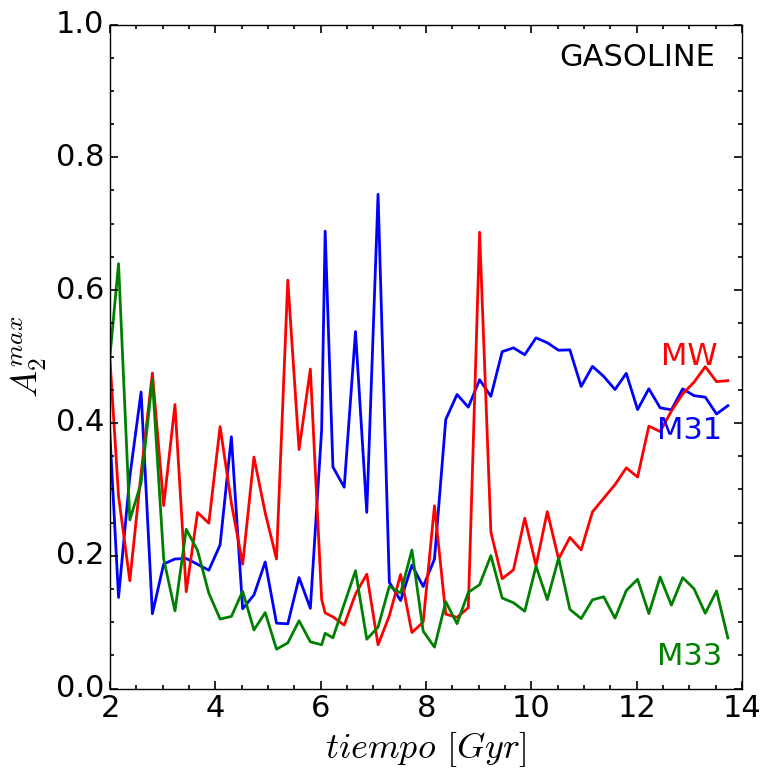

In [21]:
#Grafico de time vs A2max (en 2r50)
#t, A2max, krot, Mgal, Mgas, Mvir
import matplotlib.pyplot as plt

vector = (1,2,4)
vec2 = ('blue', 'red', 'green')

for i in range(0,3):
    cm=np.loadtxt('/z/dalgorry/datos_salida2/A2-krot-s'+'%s' %vector[i]+'.dat')
    
    t=cm[:,0]
    A2max=cm[:,4]
    
    #print len(t)
    #lalala
    
    time =[]
    A2=[]
    aux=range(0,len(t),1)
    for j in aux:
        time.append(t[j])
        A2.append(A2max[j])
    
    fig = plt.figure(1,figsize=(8,8))
    fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
    ax0=fig.add_subplot(111)
    ax0.plot(time,A2,'k', color = '%s'%vec2[i], lw=2)
    ax0.set_ylim(0,1)
    ax0.set_xlim(2,14)
    ax0.set_xlabel(u'$tiempo$ $[Gyr]$', fontsize=26)
    ax0.set_ylabel(u'$A_{2}^{max}$', fontsize=26)
    ax0.minorticks_on()
    ax0.tick_params( labelsize=22)
    ax0.tick_params('both', length=3, width=1.2,which='minor')
    ax0.tick_params('both', length=6, width=1.2,which='major')

plt.text(x=12 , y=0.95 , s = 'GASOLINE',color ='k',fontsize = 22, va = 'center', ha = 'center')
plt.text(x=13 , y=0.41 , s = 'M31',color ='blue',fontsize = 22, va = 'top', ha = 'center')
plt.text(x=13 , y=0.5 , s = 'MW',color ='red',fontsize = 22, va = 'center', ha = 'center')
plt.text(x=13 , y=0.07 , s = 'M33',color ='green',fontsize = 22, va = 'top', ha = 'center')
#fig.savefig('/z/dalgorry/plots3/GS_time_vs_A2max.png', dpi = 100)
plt.show()

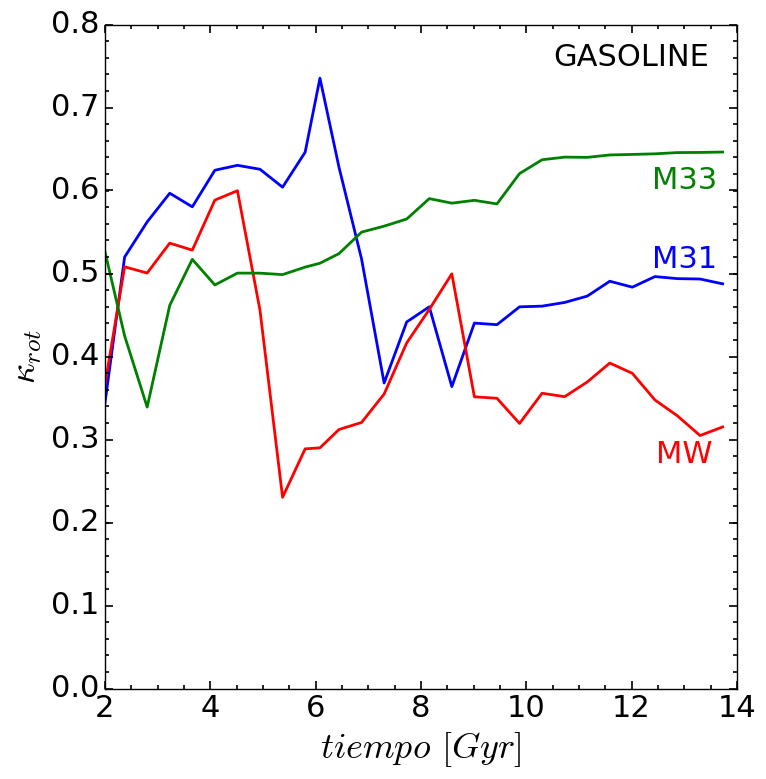

In [16]:
# Grafico de time vs krot
#t, A2max, krot, Mgal, Mgas, Mvir
import matplotlib.pyplot as plt

vector = (1,2,4)
vec2 = ('blue', 'red', 'green')

for i in range(0,3):
    cm=np.loadtxt('/z/dalgorry/datos_salida2/A2-krot-s'+'%s' %vector[i]+'.dat')
    
    t=cm[:,0]
    krot =cm[:,5]
    
    time =[]
    kk=[]
    aux=range(0,len(t),2)
    for j in aux:
        time.append(t[j])
        kk.append(krot[j])
    
    fig = plt.figure(1,figsize=(8,8))
    fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
    ax0=fig.add_subplot(111)
    ax0.plot(time,kk,'k', lw=2, color = '%s'%vec2[i])
    ax0.set_ylim(0,0.8)
    ax0.set_xlim(2,14)
    ax0.set_xlabel(u'$tiempo$ $[Gyr]$', fontsize=26)
    ax0.set_ylabel(u'$\kappa_{rot}$', fontsize=26)
    ax0.minorticks_on()
    ax0.tick_params( labelsize=22)
    ax0.tick_params('both', length=3, width=1.2,which='minor')
    ax0.tick_params('both', length=6, width=1.2,which='major')
    
plt.text(x=12 , y=0.76 , s = 'GASOLINE',color ='k',fontsize = 22, va = 'center', ha = 'center')
plt.text(x=13 , y=0.5 , s = 'M31',color ='blue',fontsize = 22, va = 'bottom', ha = 'center')
plt.text(x=13 , y=0.3 , s = 'MW',color ='red',fontsize = 22, va = 'top', ha = 'center')
plt.text(x=13 , y=0.63 , s = 'M33',color ='green',fontsize = 22, va = 'top', ha = 'center')
fig.savefig('/z/dalgorry/plots3/GS_time_vs_krot.png', dpi = 100)
plt.show()
    

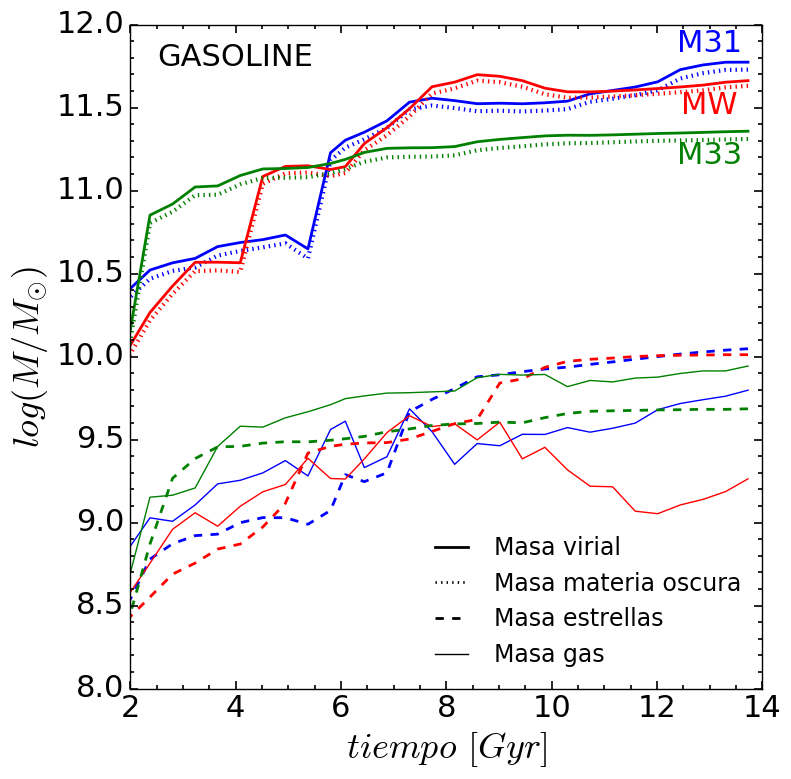

In [2]:
# Grafico de time vs Mgal
#t, A2max, krot, Mgal, Mgas
import matplotlib.pyplot as plt

vector = (1,2,4)
vec2 = ('blue', 'red', 'green')
vector3=('M31', 'MW', 'M33')
j=0
 
for i in range(0,3):

    cm=np.loadtxt('/z/dalgorry/datos_salida2/A2-krot-s'+'%s' %vector[i]+'.dat')
    
    t=cm[:,0]
    Mgal=cm[:,6]
    Mgas=cm[:,7]
    Mvir=cm[:,8]
    Mdrk=cm[:,9]
    
    time =[]
    m_gal=[]
    m_gas=[]
    m_vir=[]
    m_drk=[]
    aux=range(0,len(t),2)
    for j in aux:
        time.append(t[j])
        m_gal.append(Mgal[j])
        m_gas.append(Mgas[j])
        m_vir.append(Mvir[j])
        m_drk.append(Mdrk[j])
    
    fig = plt.figure(1,figsize=(8,8))
    fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
    ax0=fig.add_subplot(111)
    ax0.plot(time,m_gal,'--', lw=2, color = '%s'%vec2[i], label= 'Masa estrellas')
    ax0.plot(time,m_gas,'k', lw=1, color = '%s'%vec2[i], label = 'Masa gas')
    ax0.plot(time,m_drk,':', lw=3, color = '%s'%vec2[i], label='Masa materia oscura')
    ax0.plot(time,m_vir,'k', lw=2, color = '%s'%vec2[i], label='Masa virial')
    ax0.set_ylim(8,12)
    ax0.set_xlim(2,14)
    ax0.set_xlabel(u'$tiempo$ $[Gyr]$', fontsize=26)
    ax0.set_ylabel(u'$log(M/M_{\odot})$', fontsize=26)
    ax0.minorticks_on()
    ax0.tick_params( labelsize=22)
    ax0.tick_params('both', length=3, width=1.2,which='minor')
    ax0.tick_params('both', length=6, width=1.2,which='major')

handles, labels = ax0.get_legend_handles_labels()
#Create custom artists
Estrellas = plt.Line2D((0,1),(0,0), color='k', linestyle='--',lw=2)
Gas = plt.Line2D((0,1),(0,0), color='k', linestyle='-', lw=1)
M_oscura = plt.Line2D((0,1),(0,0), color='k',  linestyle=':', lw=2)
M_virial = plt.Line2D((0,1),(0,0), color='k',  linestyle='-', lw=2)
#Create legend from custom artist/label lists
ax0.legend([M_virial, M_oscura, Estrellas, Gas],['Masa virial','Masa materia oscura','Masa estrellas', 'Masa gas'],
           fontsize=17, frameon=False, loc=4, numpoints=4 , ncol=1)
    
plt.text(x=4 , y=11.8 , s = 'GASOLINE',color ='k',fontsize = 22, va = 'center', ha = 'center')

#plt.text(x=3 , y=11.5 , s = '$Masa\:virial$',color ='k',fontsize = 22, va = 'center', ha = 'left')
#plt.text(x=13 , y=10.1 , s = 'M31',color ='blue',fontsize = 22, va = 'bottom', ha = 'center')
#plt.text(x=13 , y=9.95 , s = 'MW',color ='red',fontsize = 22, va = 'top', ha = 'center')
#plt.text(x=13 , y=9.6 , s = 'M33',color ='green',fontsize = 22, va = 'top', ha = 'center')

#plt.text(x=3 , y=9.8 , s = '$Masa\:estelar$',color ='k',fontsize = 22, va = 'center', ha = 'left')
plt.text(x=13 , y=11.8 , s = 'M31',color ='blue',fontsize = 22, va = 'bottom', ha = 'center')
plt.text(x=13 , y=11.6 , s = 'MW',color ='red',fontsize = 22, va = 'top', ha = 'center')
plt.text(x=13 , y=11.3 , s = 'M33',color ='green',fontsize = 22, va = 'top', ha = 'center')
fig.savefig('/z/dalgorry/plots3/GS_time_vs_Mgal-vir.png', dpi = 100)
plt.show()

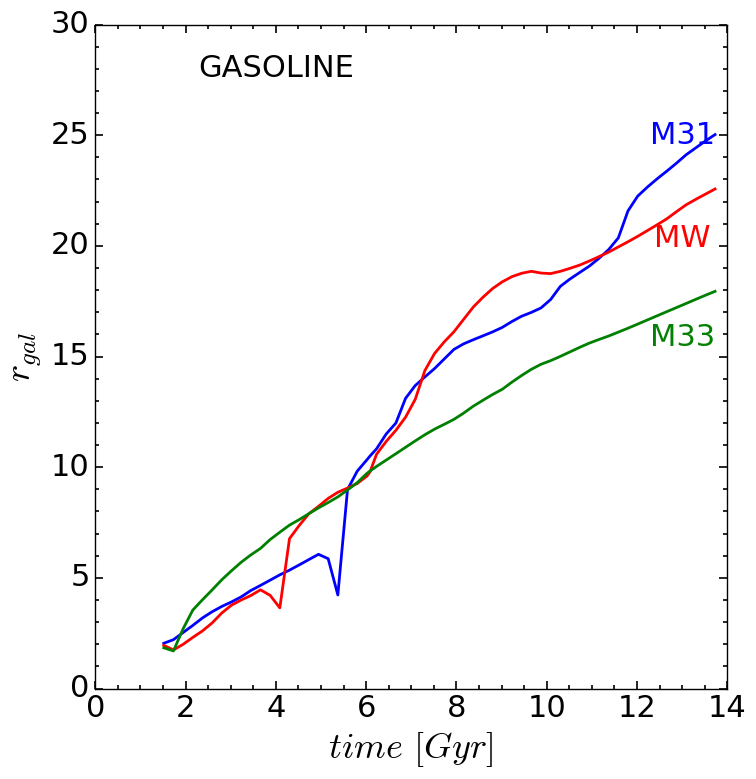

In [18]:
# Grafico de time vs r
#t, A2max, krot, Mgal, Mgas, Mvir
import matplotlib.pyplot as plt

vector = (1,2,4)
vec2 = ('blue', 'red', 'green')

for i in range(0,3):
    cm=np.loadtxt('/z/dalgorry/datos_salida2/A2-krot-s'+'%s' %vector[i]+'.dat')
    
    t=cm[:,0]
    rgal =cm[:,2]
    
    time =[]
    r_gal=[]
    aux=range(0,len(t),1)
    for j in aux:
        time.append(t[j])
        r_gal.append(rgal[j])
    
    fig = plt.figure(1,figsize=(8,8))
    fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
    ax0=fig.add_subplot(111)
    ax0.plot(time,r_gal,'k', lw=2, color = '%s'%vec2[i])
    #ax0.set_ylim(0,0.7)
    ax0.set_xlabel(u'$time$ $[Gyr]$', fontsize=26)
    ax0.set_ylabel(u'$r_{gal}$', fontsize=26)
    ax0.minorticks_on()
    ax0.tick_params( labelsize=22)
    ax0.tick_params('both', length=3, width=1.2,which='minor')
    ax0.tick_params('both', length=6, width=1.2,which='major')
    
plt.text(x=4 , y=28 , s = 'GASOLINE',color ='k',fontsize = 22, va = 'center', ha = 'center')
plt.text(x=13 , y=25 , s = 'M31',color ='blue',fontsize = 22, va = 'center', ha = 'center')
plt.text(x=13 , y=21 , s = 'MW',color ='red',fontsize = 22, va = 'top', ha = 'center')
plt.text(x=13 , y=16.5 , s = 'M33',color ='green',fontsize = 22, va = 'top', ha = 'center')
#fig.savefig('/z/dalgorry/plots2/GS_time_vs_rgal.png', dpi = 100)
plt.show()

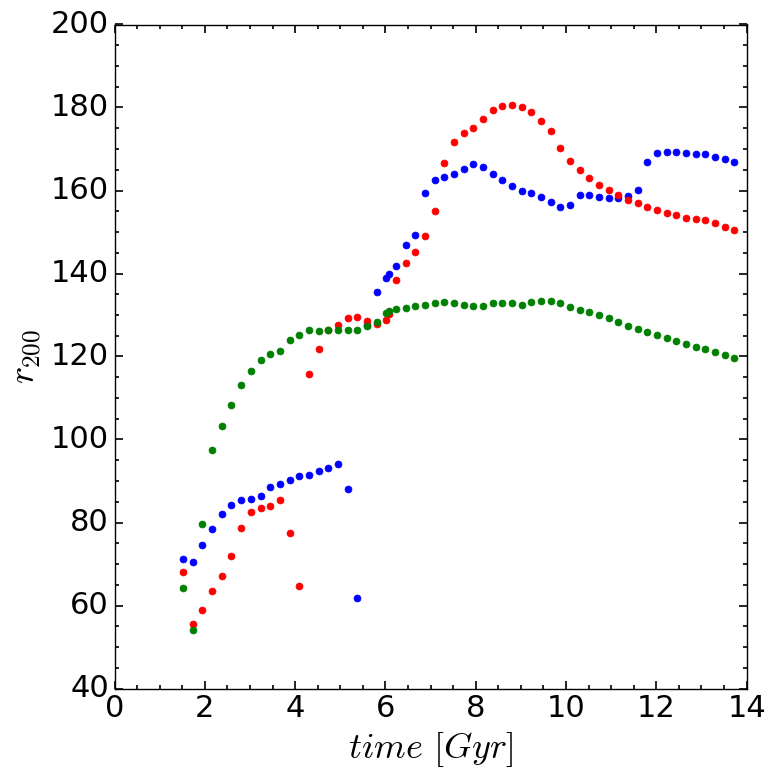

In [8]:
 #Grafico de time vs r
#t, A2max, krot, Mgal, Mgas, Mvir
import matplotlib.pyplot as plt

vector = (1,2,4)
vec2 = ('blue', 'red', 'green')

for i in range(0,3):
    cm=np.loadtxt('/z/dalgorry/datos_salida2/A2-krot-s'+'%s' %vector[i]+'.dat')
    
    t=cm[:,0]
    rvir =cm[:,3]
    
    time =[]
    r_vir=[]
    aux=range(0,len(t),1)
    for j in aux:
        time.append(t[j])
        r_vir.append(rvir[j])
    
    fig = plt.figure(1,figsize=(8,8))
    fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
    ax0=fig.add_subplot(111)
    ax0.plot(time,r_vir,'.k', markersize=10, color = '%s'%vec2[i])
    #ax0.set_ylim(0,0.7)
    ax0.set_xlabel(u'$time$ $[Gyr]$', fontsize=26)
    ax0.set_ylabel(u'$r_{200}$', fontsize=26)
    ax0.minorticks_on()
    ax0.tick_params( labelsize=22)
    ax0.tick_params('both', length=3, width=1.2,which='minor')
    ax0.tick_params('both', length=6, width=1.2,which='major')
    
#plt.text(x=4 , y=28 , s = 'GASOLINE',color ='k',fontsize = 22, va = 'center', ha = 'center')
#plt.text(x=13 , y=25 , s = 'M31',color ='blue',fontsize = 22, va = 'center', ha = 'center')
#plt.text(x=13 , y=21 , s = 'MW',color ='red',fontsize = 22, va = 'top', ha = 'center')
#plt.text(x=13 , y=16.5 , s = 'M33',color ='green',fontsize = 22, va = 'top', ha = 'center')
#fig.savefig('/z/dalgorry/plots2/GS_time_vs_rgal.png', dpi = 100)
plt.show()